In [1]:
import glob
import pandas as pd
import numpy as np
import imageio
from skimage.transform import resize
from scipy import misc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau 
from keras.utils import np_utils, normalize

Using TensorFlow backend.


In [4]:
# Use this to supress warnings from scipy in the meantime
import warnings
warnings.filterwarnings("ignore")

In [5]:
PATH_DATA = './Data/'
PATH_IMAGES = glob.glob('./Images/*.jpg')

In [6]:
df_meta = pd.read_csv(PATH_DATA + 'HAM10000_metadata.csv')

## I. EDA

In [7]:
df_meta.shape

(10015, 7)

In [8]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [9]:
df_meta.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [10]:
df_meta.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0001863,ISIC_0030282,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [11]:
df_meta.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
8671,HAM_0002497,ISIC_0025443,nv,histo,75.0,male,back
5564,HAM_0001365,ISIC_0026307,nv,follow_up,40.0,male,lower extremity
5345,HAM_0002168,ISIC_0028002,nv,follow_up,35.0,male,back
3456,HAM_0004851,ISIC_0031219,nv,follow_up,40.0,female,lower extremity
307,HAM_0001995,ISIC_0024581,bkl,histo,40.0,male,lower extremity
6978,HAM_0002349,ISIC_0025735,nv,histo,70.0,male,upper extremity
8507,HAM_0001458,ISIC_0032136,nv,histo,45.0,female,back
7974,HAM_0004581,ISIC_0032539,nv,consensus,55.0,male,unknown
8080,HAM_0000054,ISIC_0026498,nv,histo,35.0,female,back
2975,HAM_0005026,ISIC_0028728,bcc,histo,40.0,female,abdomen


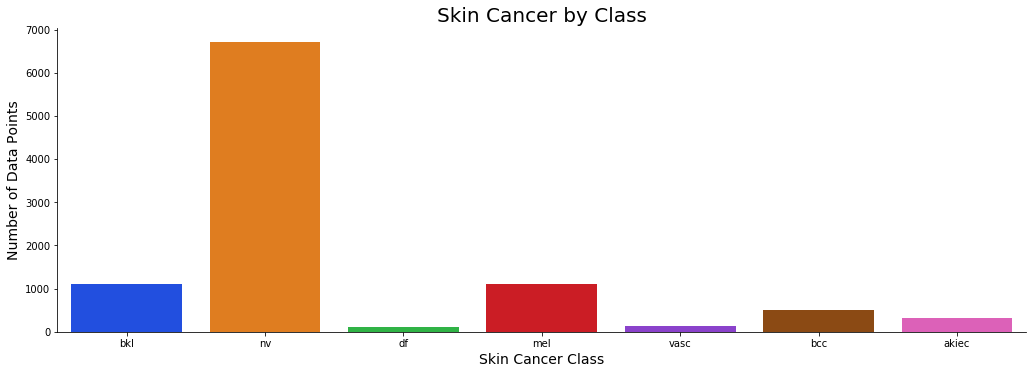

In [12]:
# For this project we need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Class', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)

### There is a class imbalance here with 'nv' comprising more than 65% of the overall data, this will have an impact later during the classification
***

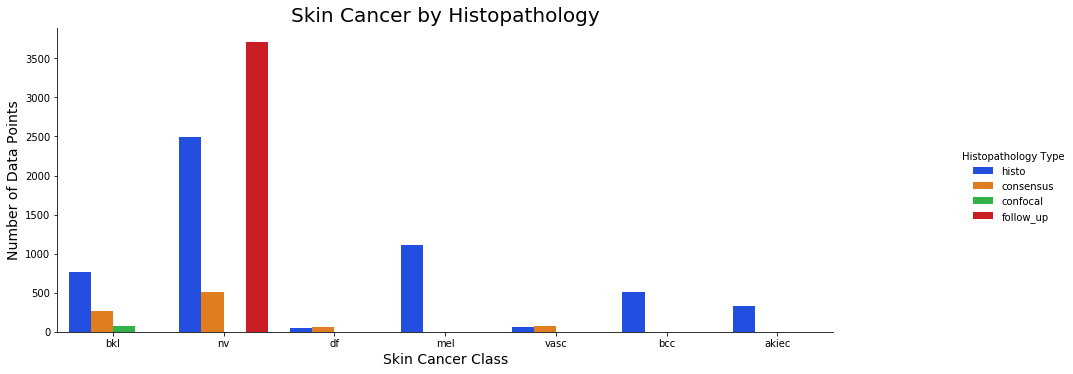

In [13]:
# Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Histopathology Type')

### It seems that all of 'nv' are confirmed through follow-up, this behavior is not seen for other cancer class
***

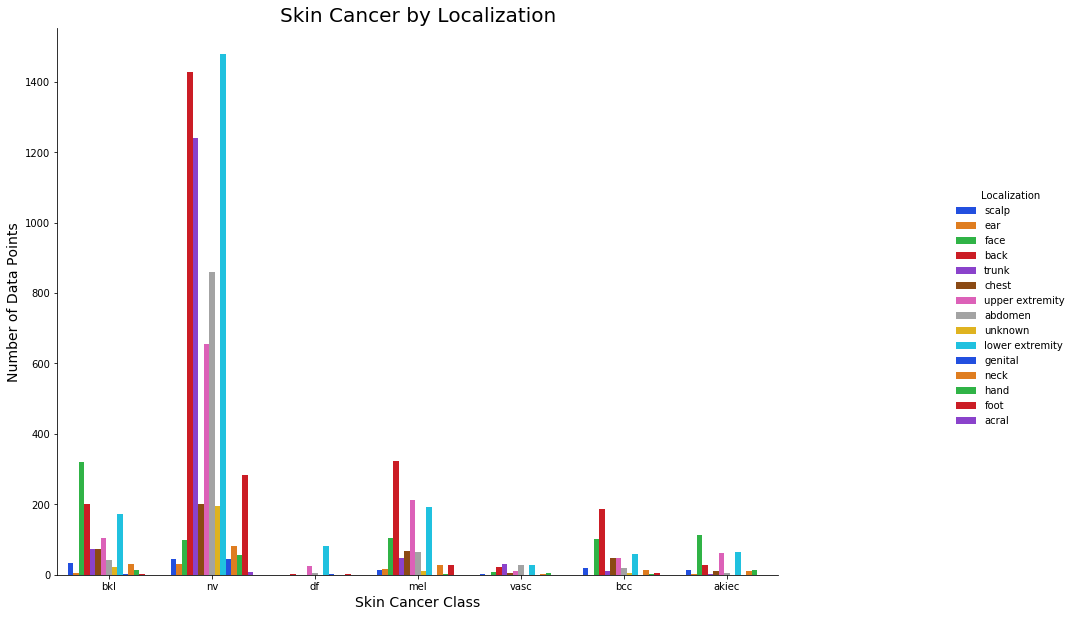

In [14]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Localization')

### Skin cancer seems to have more occurence in the back and lower extrimity of people, may indicate over-exposure to the sun in water activities
***

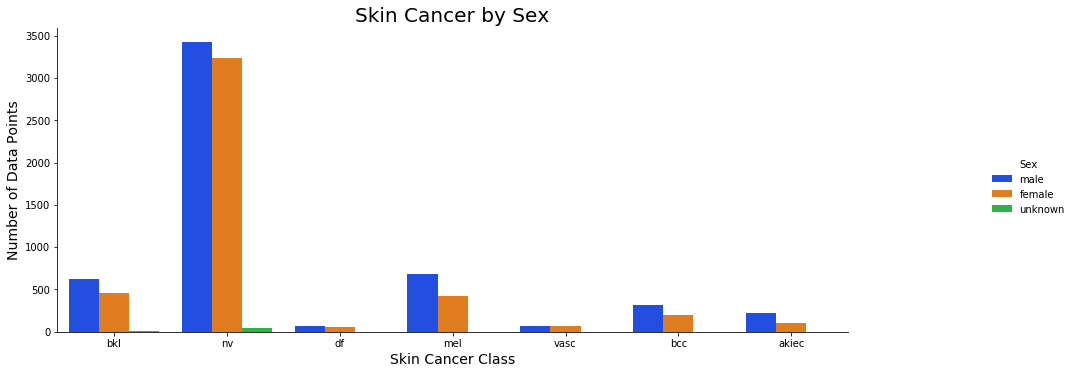

In [15]:
# Skin Cancer occurence by Gender
g = sns.catplot(x="dx", kind="count", hue="sex", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')

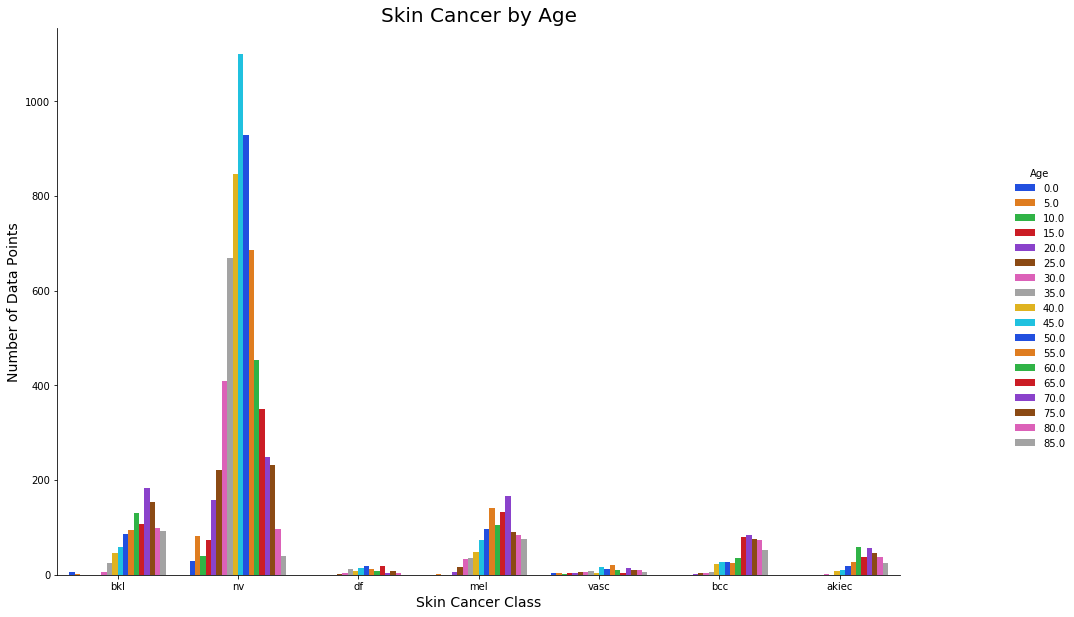

In [16]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

### While 'nv' is the most common of cancer class in the dataset, it seems to occur more for middle age while for other cancer class, it seems to occur more at a later age
***

## II. Load the Images and prepare for Train/Test Split

In [17]:
# Prepare Train and Test Data
df_meta = df_meta.set_index('image_id')
y = pd.get_dummies(df_meta[['dx']])
y_train, y_test = train_test_split(y, test_size=0.1, random_state=42)

In [18]:
# Original Size: 600*450
# Metho: Load all Images and Resize to 30%, with normalization

TARGET_SIZE = (180, 135)

x_train, x_test = [], []
for image_id in y_train.index.values:
    # Uses too much memory, will revert first to scipy
    # image = imageio.imread('./Images/{}.jpg'.format(image_id))
    # image = resize(image, output_shape=(360, 270), anti_aliasing=False, mode='constant')
    
    image = misc.imread('./Images/{}.jpg'.format(image_id))
    image = misc.imresize(image, size=TARGET_SIZE, interp='nearest')
    image = normalize(image)
    x_train.append(image)
    print('Completed processing {}.jpg'.format(image_id))

x_train = np.asarray(x_train)

for image_id in y_test.index.values:
    # Uses too much memory, will revert first to scipy
    # image = imageio.imread('./Images/{}.jpg'.format(image_id))
    # image = resize(image, output_shape=(360, 270), anti_aliasing=False, mode='constant')
    
    image = misc.imread('./Images/{}.jpg'.format(image_id))
    image = misc.imresize(image, size=TARGET_SIZE, interp='nearest')
    image = normalize(image)
    x_test.append(image)
    print('Completed processing {}.jpg'.format(image_id))

x_test = np.asarray(x_test)

Completed processing ISIC_0029650.jpg
Completed processing ISIC_0027956.jpg
Completed processing ISIC_0025154.jpg
Completed processing ISIC_0034101.jpg
Completed processing ISIC_0028149.jpg
Completed processing ISIC_0030191.jpg
Completed processing ISIC_0026801.jpg
Completed processing ISIC_0025572.jpg
Completed processing ISIC_0028332.jpg
Completed processing ISIC_0028530.jpg
Completed processing ISIC_0027034.jpg
Completed processing ISIC_0027030.jpg
Completed processing ISIC_0024767.jpg
Completed processing ISIC_0026580.jpg
Completed processing ISIC_0031561.jpg
Completed processing ISIC_0028283.jpg
Completed processing ISIC_0034249.jpg
Completed processing ISIC_0028480.jpg
Completed processing ISIC_0031764.jpg
Completed processing ISIC_0027006.jpg
Completed processing ISIC_0025522.jpg
Completed processing ISIC_0027858.jpg
Completed processing ISIC_0029297.jpg
Completed processing ISIC_0026358.jpg
Completed processing ISIC_0029593.jpg
Completed processing ISIC_0032694.jpg
Completed pr

Completed processing ISIC_0029337.jpg
Completed processing ISIC_0032443.jpg
Completed processing ISIC_0033902.jpg
Completed processing ISIC_0028124.jpg
Completed processing ISIC_0033659.jpg
Completed processing ISIC_0030936.jpg
Completed processing ISIC_0031716.jpg
Completed processing ISIC_0031642.jpg
Completed processing ISIC_0031942.jpg
Completed processing ISIC_0031891.jpg
Completed processing ISIC_0032815.jpg
Completed processing ISIC_0026307.jpg
Completed processing ISIC_0033121.jpg
Completed processing ISIC_0030186.jpg
Completed processing ISIC_0027653.jpg
Completed processing ISIC_0024879.jpg
Completed processing ISIC_0031812.jpg
Completed processing ISIC_0027774.jpg
Completed processing ISIC_0032848.jpg
Completed processing ISIC_0031940.jpg
Completed processing ISIC_0031161.jpg
Completed processing ISIC_0033449.jpg
Completed processing ISIC_0027582.jpg
Completed processing ISIC_0027436.jpg
Completed processing ISIC_0033025.jpg
Completed processing ISIC_0027001.jpg
Completed pr

Completed processing ISIC_0030700.jpg
Completed processing ISIC_0032103.jpg
Completed processing ISIC_0027295.jpg
Completed processing ISIC_0029136.jpg
Completed processing ISIC_0031298.jpg
Completed processing ISIC_0029465.jpg
Completed processing ISIC_0032713.jpg
Completed processing ISIC_0026363.jpg
Completed processing ISIC_0033024.jpg
Completed processing ISIC_0025993.jpg
Completed processing ISIC_0031382.jpg
Completed processing ISIC_0033594.jpg
Completed processing ISIC_0030266.jpg
Completed processing ISIC_0027757.jpg
Completed processing ISIC_0032995.jpg
Completed processing ISIC_0026330.jpg
Completed processing ISIC_0025904.jpg
Completed processing ISIC_0025327.jpg
Completed processing ISIC_0027302.jpg
Completed processing ISIC_0028532.jpg
Completed processing ISIC_0026240.jpg
Completed processing ISIC_0032072.jpg
Completed processing ISIC_0029538.jpg
Completed processing ISIC_0025091.jpg
Completed processing ISIC_0032700.jpg
Completed processing ISIC_0028022.jpg
Completed pr

Completed processing ISIC_0029694.jpg
Completed processing ISIC_0033821.jpg
Completed processing ISIC_0034024.jpg
Completed processing ISIC_0029801.jpg
Completed processing ISIC_0030156.jpg
Completed processing ISIC_0031781.jpg
Completed processing ISIC_0031766.jpg
Completed processing ISIC_0031904.jpg
Completed processing ISIC_0031122.jpg
Completed processing ISIC_0025070.jpg
Completed processing ISIC_0032233.jpg
Completed processing ISIC_0026176.jpg
Completed processing ISIC_0029393.jpg
Completed processing ISIC_0024379.jpg
Completed processing ISIC_0024952.jpg
Completed processing ISIC_0024616.jpg
Completed processing ISIC_0024481.jpg
Completed processing ISIC_0034194.jpg
Completed processing ISIC_0031875.jpg
Completed processing ISIC_0025286.jpg
Completed processing ISIC_0024595.jpg
Completed processing ISIC_0032642.jpg
Completed processing ISIC_0030174.jpg
Completed processing ISIC_0024598.jpg
Completed processing ISIC_0030818.jpg
Completed processing ISIC_0025215.jpg
Completed pr

Completed processing ISIC_0033484.jpg
Completed processing ISIC_0030194.jpg
Completed processing ISIC_0030497.jpg
Completed processing ISIC_0032585.jpg
Completed processing ISIC_0027470.jpg
Completed processing ISIC_0030979.jpg
Completed processing ISIC_0031758.jpg
Completed processing ISIC_0028077.jpg
Completed processing ISIC_0029303.jpg
Completed processing ISIC_0033834.jpg
Completed processing ISIC_0030948.jpg
Completed processing ISIC_0031986.jpg
Completed processing ISIC_0029710.jpg
Completed processing ISIC_0033571.jpg
Completed processing ISIC_0026624.jpg
Completed processing ISIC_0028029.jpg
Completed processing ISIC_0030806.jpg
Completed processing ISIC_0027569.jpg
Completed processing ISIC_0034319.jpg
Completed processing ISIC_0030605.jpg
Completed processing ISIC_0028623.jpg
Completed processing ISIC_0024488.jpg
Completed processing ISIC_0027132.jpg
Completed processing ISIC_0028448.jpg
Completed processing ISIC_0031838.jpg
Completed processing ISIC_0025764.jpg
Completed pr

Completed processing ISIC_0030168.jpg
Completed processing ISIC_0031264.jpg
Completed processing ISIC_0027915.jpg
Completed processing ISIC_0026694.jpg
Completed processing ISIC_0031992.jpg
Completed processing ISIC_0032747.jpg
Completed processing ISIC_0025597.jpg
Completed processing ISIC_0031024.jpg
Completed processing ISIC_0028850.jpg
Completed processing ISIC_0031560.jpg
Completed processing ISIC_0026153.jpg
Completed processing ISIC_0025263.jpg
Completed processing ISIC_0026996.jpg
Completed processing ISIC_0031668.jpg
Completed processing ISIC_0025846.jpg
Completed processing ISIC_0027405.jpg
Completed processing ISIC_0033271.jpg
Completed processing ISIC_0024352.jpg
Completed processing ISIC_0030823.jpg
Completed processing ISIC_0029788.jpg
Completed processing ISIC_0032289.jpg
Completed processing ISIC_0029804.jpg
Completed processing ISIC_0030059.jpg
Completed processing ISIC_0026664.jpg
Completed processing ISIC_0025716.jpg
Completed processing ISIC_0024638.jpg
Completed pr

Completed processing ISIC_0028066.jpg
Completed processing ISIC_0027529.jpg
Completed processing ISIC_0029850.jpg
Completed processing ISIC_0026068.jpg
Completed processing ISIC_0028967.jpg
Completed processing ISIC_0025386.jpg
Completed processing ISIC_0026085.jpg
Completed processing ISIC_0026821.jpg
Completed processing ISIC_0026643.jpg
Completed processing ISIC_0030900.jpg
Completed processing ISIC_0027036.jpg
Completed processing ISIC_0025678.jpg
Completed processing ISIC_0032684.jpg
Completed processing ISIC_0032084.jpg
Completed processing ISIC_0024626.jpg
Completed processing ISIC_0027161.jpg
Completed processing ISIC_0027923.jpg
Completed processing ISIC_0029662.jpg
Completed processing ISIC_0028366.jpg
Completed processing ISIC_0024586.jpg
Completed processing ISIC_0030470.jpg
Completed processing ISIC_0028514.jpg
Completed processing ISIC_0032355.jpg
Completed processing ISIC_0029283.jpg
Completed processing ISIC_0031239.jpg
Completed processing ISIC_0024765.jpg
Completed pr

Completed processing ISIC_0030226.jpg
Completed processing ISIC_0024749.jpg
Completed processing ISIC_0025061.jpg
Completed processing ISIC_0025689.jpg
Completed processing ISIC_0032213.jpg
Completed processing ISIC_0032833.jpg
Completed processing ISIC_0025926.jpg
Completed processing ISIC_0033937.jpg
Completed processing ISIC_0031663.jpg
Completed processing ISIC_0026977.jpg
Completed processing ISIC_0029277.jpg
Completed processing ISIC_0029588.jpg
Completed processing ISIC_0024843.jpg
Completed processing ISIC_0027477.jpg
Completed processing ISIC_0025257.jpg
Completed processing ISIC_0034207.jpg
Completed processing ISIC_0032463.jpg
Completed processing ISIC_0033987.jpg
Completed processing ISIC_0029106.jpg
Completed processing ISIC_0026731.jpg
Completed processing ISIC_0028949.jpg
Completed processing ISIC_0032953.jpg
Completed processing ISIC_0027383.jpg
Completed processing ISIC_0028864.jpg
Completed processing ISIC_0029295.jpg
Completed processing ISIC_0025217.jpg
Completed pr

Completed processing ISIC_0029946.jpg
Completed processing ISIC_0030665.jpg
Completed processing ISIC_0031720.jpg
Completed processing ISIC_0026146.jpg
Completed processing ISIC_0031063.jpg
Completed processing ISIC_0025920.jpg
Completed processing ISIC_0032048.jpg
Completed processing ISIC_0027145.jpg
Completed processing ISIC_0032439.jpg
Completed processing ISIC_0030662.jpg
Completed processing ISIC_0031591.jpg
Completed processing ISIC_0028894.jpg
Completed processing ISIC_0030358.jpg
Completed processing ISIC_0030639.jpg
Completed processing ISIC_0032306.jpg
Completed processing ISIC_0032753.jpg
Completed processing ISIC_0028082.jpg
Completed processing ISIC_0032733.jpg
Completed processing ISIC_0027081.jpg
Completed processing ISIC_0026458.jpg
Completed processing ISIC_0028663.jpg
Completed processing ISIC_0033157.jpg
Completed processing ISIC_0025394.jpg
Completed processing ISIC_0033776.jpg
Completed processing ISIC_0030078.jpg
Completed processing ISIC_0031695.jpg
Completed pr

Completed processing ISIC_0025995.jpg
Completed processing ISIC_0029048.jpg
Completed processing ISIC_0027268.jpg
Completed processing ISIC_0025092.jpg
Completed processing ISIC_0026786.jpg
Completed processing ISIC_0026374.jpg
Completed processing ISIC_0033575.jpg
Completed processing ISIC_0032686.jpg
Completed processing ISIC_0033103.jpg
Completed processing ISIC_0030504.jpg
Completed processing ISIC_0025878.jpg
Completed processing ISIC_0030593.jpg
Completed processing ISIC_0032481.jpg
Completed processing ISIC_0030599.jpg
Completed processing ISIC_0030141.jpg
Completed processing ISIC_0031918.jpg
Completed processing ISIC_0032813.jpg
Completed processing ISIC_0030229.jpg
Completed processing ISIC_0025299.jpg
Completed processing ISIC_0031016.jpg
Completed processing ISIC_0026360.jpg
Completed processing ISIC_0024807.jpg
Completed processing ISIC_0024955.jpg
Completed processing ISIC_0029989.jpg
Completed processing ISIC_0031479.jpg
Completed processing ISIC_0029229.jpg
Completed pr

Completed processing ISIC_0033842.jpg
Completed processing ISIC_0029159.jpg
Completed processing ISIC_0031408.jpg
Completed processing ISIC_0024436.jpg
Completed processing ISIC_0031702.jpg
Completed processing ISIC_0028614.jpg
Completed processing ISIC_0032249.jpg
Completed processing ISIC_0033435.jpg
Completed processing ISIC_0027214.jpg
Completed processing ISIC_0031705.jpg
Completed processing ISIC_0031746.jpg
Completed processing ISIC_0024652.jpg
Completed processing ISIC_0025408.jpg
Completed processing ISIC_0030824.jpg
Completed processing ISIC_0031447.jpg
Completed processing ISIC_0028669.jpg
Completed processing ISIC_0031367.jpg
Completed processing ISIC_0029972.jpg
Completed processing ISIC_0031207.jpg
Completed processing ISIC_0029245.jpg
Completed processing ISIC_0034116.jpg
Completed processing ISIC_0027516.jpg
Completed processing ISIC_0029401.jpg
Completed processing ISIC_0031973.jpg
Completed processing ISIC_0032043.jpg
Completed processing ISIC_0024783.jpg
Completed pr

Completed processing ISIC_0026923.jpg
Completed processing ISIC_0029163.jpg
Completed processing ISIC_0029691.jpg
Completed processing ISIC_0034318.jpg
Completed processing ISIC_0028885.jpg
Completed processing ISIC_0025087.jpg
Completed processing ISIC_0030456.jpg
Completed processing ISIC_0033570.jpg
Completed processing ISIC_0025963.jpg
Completed processing ISIC_0028469.jpg
Completed processing ISIC_0033792.jpg
Completed processing ISIC_0032702.jpg
Completed processing ISIC_0026814.jpg
Completed processing ISIC_0026853.jpg
Completed processing ISIC_0024636.jpg
Completed processing ISIC_0029121.jpg
Completed processing ISIC_0027471.jpg
Completed processing ISIC_0025599.jpg
Completed processing ISIC_0025719.jpg
Completed processing ISIC_0031256.jpg
Completed processing ISIC_0027475.jpg
Completed processing ISIC_0030323.jpg
Completed processing ISIC_0025820.jpg
Completed processing ISIC_0032182.jpg
Completed processing ISIC_0029139.jpg
Completed processing ISIC_0027056.jpg
Completed pr

Completed processing ISIC_0024703.jpg
Completed processing ISIC_0031736.jpg
Completed processing ISIC_0029925.jpg
Completed processing ISIC_0024755.jpg
Completed processing ISIC_0032277.jpg
Completed processing ISIC_0030828.jpg
Completed processing ISIC_0033728.jpg
Completed processing ISIC_0030947.jpg
Completed processing ISIC_0024596.jpg
Completed processing ISIC_0024410.jpg
Completed processing ISIC_0033287.jpg
Completed processing ISIC_0034006.jpg
Completed processing ISIC_0026319.jpg
Completed processing ISIC_0033076.jpg
Completed processing ISIC_0028534.jpg
Completed processing ISIC_0033710.jpg
Completed processing ISIC_0031565.jpg
Completed processing ISIC_0028860.jpg
Completed processing ISIC_0033047.jpg
Completed processing ISIC_0033218.jpg
Completed processing ISIC_0026161.jpg
Completed processing ISIC_0028649.jpg
Completed processing ISIC_0031369.jpg
Completed processing ISIC_0025103.jpg
Completed processing ISIC_0028346.jpg
Completed processing ISIC_0029305.jpg
Completed pr

Completed processing ISIC_0031684.jpg
Completed processing ISIC_0030246.jpg
Completed processing ISIC_0024396.jpg
Completed processing ISIC_0032390.jpg
Completed processing ISIC_0027166.jpg
Completed processing ISIC_0028745.jpg
Completed processing ISIC_0026872.jpg
Completed processing ISIC_0025839.jpg
Completed processing ISIC_0026903.jpg
Completed processing ISIC_0026044.jpg
Completed processing ISIC_0031958.jpg
Completed processing ISIC_0025346.jpg
Completed processing ISIC_0027726.jpg
Completed processing ISIC_0034015.jpg
Completed processing ISIC_0030842.jpg
Completed processing ISIC_0026252.jpg
Completed processing ISIC_0033046.jpg
Completed processing ISIC_0024742.jpg
Completed processing ISIC_0028980.jpg
Completed processing ISIC_0027167.jpg
Completed processing ISIC_0027460.jpg
Completed processing ISIC_0031949.jpg
Completed processing ISIC_0032799.jpg
Completed processing ISIC_0031054.jpg
Completed processing ISIC_0032255.jpg
Completed processing ISIC_0030819.jpg
Completed pr

Completed processing ISIC_0033881.jpg
Completed processing ISIC_0025293.jpg
Completed processing ISIC_0025967.jpg
Completed processing ISIC_0024592.jpg
Completed processing ISIC_0030932.jpg
Completed processing ISIC_0026524.jpg
Completed processing ISIC_0027364.jpg
Completed processing ISIC_0028834.jpg
Completed processing ISIC_0026556.jpg
Completed processing ISIC_0027590.jpg
Completed processing ISIC_0026124.jpg
Completed processing ISIC_0028251.jpg
Completed processing ISIC_0026668.jpg
Completed processing ISIC_0029615.jpg
Completed processing ISIC_0032198.jpg
Completed processing ISIC_0024845.jpg
Completed processing ISIC_0029561.jpg
Completed processing ISIC_0028991.jpg
Completed processing ISIC_0028512.jpg
Completed processing ISIC_0024661.jpg
Completed processing ISIC_0027882.jpg
Completed processing ISIC_0033580.jpg
Completed processing ISIC_0030845.jpg
Completed processing ISIC_0025728.jpg
Completed processing ISIC_0031726.jpg
Completed processing ISIC_0030699.jpg
Completed pr

Completed processing ISIC_0031520.jpg
Completed processing ISIC_0032279.jpg
Completed processing ISIC_0024710.jpg
Completed processing ISIC_0028342.jpg
Completed processing ISIC_0031434.jpg
Completed processing ISIC_0027655.jpg
Completed processing ISIC_0024820.jpg
Completed processing ISIC_0029664.jpg
Completed processing ISIC_0029127.jpg
Completed processing ISIC_0024463.jpg
Completed processing ISIC_0026591.jpg
Completed processing ISIC_0025804.jpg
Completed processing ISIC_0032140.jpg
Completed processing ISIC_0024530.jpg
Completed processing ISIC_0030300.jpg
Completed processing ISIC_0031543.jpg
Completed processing ISIC_0025944.jpg
Completed processing ISIC_0027707.jpg
Completed processing ISIC_0025062.jpg
Completed processing ISIC_0025313.jpg
Completed processing ISIC_0026162.jpg
Completed processing ISIC_0029839.jpg
Completed processing ISIC_0033636.jpg
Completed processing ISIC_0027184.jpg
Completed processing ISIC_0024612.jpg
Completed processing ISIC_0033908.jpg
Completed pr

Completed processing ISIC_0027579.jpg
Completed processing ISIC_0026471.jpg
Completed processing ISIC_0028020.jpg
Completed processing ISIC_0025759.jpg
Completed processing ISIC_0030402.jpg
Completed processing ISIC_0030846.jpg
Completed processing ISIC_0026762.jpg
Completed processing ISIC_0028961.jpg
Completed processing ISIC_0030409.jpg
Completed processing ISIC_0025100.jpg
Completed processing ISIC_0030158.jpg
Completed processing ISIC_0025041.jpg
Completed processing ISIC_0033558.jpg
Completed processing ISIC_0032434.jpg
Completed processing ISIC_0025185.jpg
Completed processing ISIC_0033750.jpg
Completed processing ISIC_0024548.jpg
Completed processing ISIC_0032643.jpg
Completed processing ISIC_0032580.jpg
Completed processing ISIC_0031805.jpg
Completed processing ISIC_0031047.jpg
Completed processing ISIC_0027425.jpg
Completed processing ISIC_0025111.jpg
Completed processing ISIC_0026758.jpg
Completed processing ISIC_0029530.jpg
Completed processing ISIC_0034295.jpg
Completed pr

Completed processing ISIC_0030779.jpg
Completed processing ISIC_0025665.jpg
Completed processing ISIC_0027856.jpg
Completed processing ISIC_0034091.jpg
Completed processing ISIC_0024605.jpg
Completed processing ISIC_0028835.jpg
Completed processing ISIC_0030112.jpg
Completed processing ISIC_0027559.jpg
Completed processing ISIC_0034059.jpg
Completed processing ISIC_0029224.jpg
Completed processing ISIC_0024353.jpg
Completed processing ISIC_0029160.jpg
Completed processing ISIC_0031390.jpg
Completed processing ISIC_0028334.jpg
Completed processing ISIC_0031487.jpg
Completed processing ISIC_0028409.jpg
Completed processing ISIC_0028936.jpg
Completed processing ISIC_0029623.jpg
Completed processing ISIC_0029518.jpg
Completed processing ISIC_0026917.jpg
Completed processing ISIC_0033265.jpg
Completed processing ISIC_0030135.jpg
Completed processing ISIC_0026204.jpg
Completed processing ISIC_0031202.jpg
Completed processing ISIC_0034199.jpg
Completed processing ISIC_0024799.jpg
Completed pr

Completed processing ISIC_0032597.jpg
Completed processing ISIC_0031556.jpg
Completed processing ISIC_0027979.jpg
Completed processing ISIC_0031004.jpg
Completed processing ISIC_0028359.jpg
Completed processing ISIC_0027878.jpg
Completed processing ISIC_0032209.jpg
Completed processing ISIC_0024989.jpg
Completed processing ISIC_0025864.jpg
Completed processing ISIC_0031886.jpg
Completed processing ISIC_0028198.jpg
Completed processing ISIC_0027796.jpg
Completed processing ISIC_0029489.jpg
Completed processing ISIC_0026866.jpg
Completed processing ISIC_0031620.jpg
Completed processing ISIC_0025843.jpg
Completed processing ISIC_0029285.jpg
Completed processing ISIC_0030155.jpg
Completed processing ISIC_0031153.jpg
Completed processing ISIC_0030994.jpg
Completed processing ISIC_0030787.jpg
Completed processing ISIC_0024432.jpg
Completed processing ISIC_0027873.jpg
Completed processing ISIC_0027296.jpg
Completed processing ISIC_0025310.jpg
Completed processing ISIC_0024512.jpg
Completed pr

Completed processing ISIC_0030084.jpg
Completed processing ISIC_0030094.jpg
Completed processing ISIC_0028840.jpg
Completed processing ISIC_0028211.jpg
Completed processing ISIC_0025562.jpg
Completed processing ISIC_0034226.jpg
Completed processing ISIC_0033430.jpg
Completed processing ISIC_0031435.jpg
Completed processing ISIC_0027169.jpg
Completed processing ISIC_0031388.jpg
Completed processing ISIC_0030827.jpg
Completed processing ISIC_0030262.jpg
Completed processing ISIC_0025135.jpg
Completed processing ISIC_0033282.jpg
Completed processing ISIC_0030862.jpg
Completed processing ISIC_0030439.jpg
Completed processing ISIC_0034206.jpg
Completed processing ISIC_0026865.jpg
Completed processing ISIC_0029667.jpg
Completed processing ISIC_0027993.jpg
Completed processing ISIC_0028442.jpg
Completed processing ISIC_0026682.jpg
Completed processing ISIC_0026315.jpg
Completed processing ISIC_0031238.jpg
Completed processing ISIC_0031200.jpg
Completed processing ISIC_0031062.jpg
Completed pr

Completed processing ISIC_0033385.jpg
Completed processing ISIC_0032020.jpg
Completed processing ISIC_0026115.jpg
Completed processing ISIC_0027964.jpg
Completed processing ISIC_0033555.jpg
Completed processing ISIC_0029845.jpg
Completed processing ISIC_0026962.jpg
Completed processing ISIC_0027711.jpg
Completed processing ISIC_0027611.jpg
Completed processing ISIC_0030922.jpg
Completed processing ISIC_0024800.jpg
Completed processing ISIC_0027014.jpg
Completed processing ISIC_0027855.jpg
Completed processing ISIC_0024588.jpg
Completed processing ISIC_0027251.jpg
Completed processing ISIC_0032748.jpg
Completed processing ISIC_0027594.jpg
Completed processing ISIC_0031086.jpg
Completed processing ISIC_0026238.jpg
Completed processing ISIC_0032278.jpg
Completed processing ISIC_0031934.jpg
Completed processing ISIC_0026019.jpg
Completed processing ISIC_0034269.jpg
Completed processing ISIC_0032682.jpg
Completed processing ISIC_0030431.jpg
Completed processing ISIC_0029403.jpg
Completed pr

Completed processing ISIC_0025153.jpg
Completed processing ISIC_0028841.jpg
Completed processing ISIC_0033452.jpg
Completed processing ISIC_0024315.jpg
Completed processing ISIC_0030628.jpg
Completed processing ISIC_0031292.jpg
Completed processing ISIC_0032637.jpg
Completed processing ISIC_0025034.jpg
Completed processing ISIC_0027795.jpg
Completed processing ISIC_0031779.jpg
Completed processing ISIC_0028912.jpg
Completed processing ISIC_0032060.jpg
Completed processing ISIC_0024549.jpg
Completed processing ISIC_0027197.jpg
Completed processing ISIC_0028352.jpg
Completed processing ISIC_0029511.jpg
Completed processing ISIC_0024629.jpg
Completed processing ISIC_0029514.jpg
Completed processing ISIC_0026788.jpg
Completed processing ISIC_0029964.jpg
Completed processing ISIC_0030197.jpg
Completed processing ISIC_0027521.jpg
Completed processing ISIC_0032721.jpg
Completed processing ISIC_0026306.jpg
Completed processing ISIC_0030708.jpg
Completed processing ISIC_0028509.jpg
Completed pr

Completed processing ISIC_0025081.jpg
Completed processing ISIC_0033593.jpg
Completed processing ISIC_0028652.jpg
Completed processing ISIC_0028182.jpg
Completed processing ISIC_0026343.jpg
Completed processing ISIC_0031043.jpg
Completed processing ISIC_0033713.jpg
Completed processing ISIC_0026273.jpg
Completed processing ISIC_0033159.jpg
Completed processing ISIC_0027584.jpg
Completed processing ISIC_0025622.jpg
Completed processing ISIC_0033634.jpg
Completed processing ISIC_0033352.jpg
Completed processing ISIC_0031224.jpg
Completed processing ISIC_0032679.jpg
Completed processing ISIC_0034174.jpg
Completed processing ISIC_0025720.jpg
Completed processing ISIC_0026828.jpg
Completed processing ISIC_0033434.jpg
Completed processing ISIC_0028478.jpg
Completed processing ISIC_0033437.jpg
Completed processing ISIC_0030150.jpg
Completed processing ISIC_0030021.jpg
Completed processing ISIC_0028625.jpg
Completed processing ISIC_0025615.jpg
Completed processing ISIC_0032984.jpg
Completed pr

Completed processing ISIC_0025974.jpg
Completed processing ISIC_0031074.jpg
Completed processing ISIC_0034066.jpg
Completed processing ISIC_0026323.jpg
Completed processing ISIC_0025028.jpg
Completed processing ISIC_0027163.jpg
Completed processing ISIC_0031228.jpg
Completed processing ISIC_0025278.jpg
Completed processing ISIC_0029184.jpg
Completed processing ISIC_0026121.jpg
Completed processing ISIC_0028989.jpg
Completed processing ISIC_0027731.jpg
Completed processing ISIC_0027363.jpg
Completed processing ISIC_0034092.jpg
Completed processing ISIC_0028786.jpg
Completed processing ISIC_0031423.jpg
Completed processing ISIC_0028687.jpg
Completed processing ISIC_0031363.jpg
Completed processing ISIC_0033525.jpg
Completed processing ISIC_0024811.jpg
Completed processing ISIC_0033738.jpg
Completed processing ISIC_0031400.jpg
Completed processing ISIC_0030581.jpg
Completed processing ISIC_0032866.jpg
Completed processing ISIC_0028470.jpg
Completed processing ISIC_0031500.jpg
Completed pr

Completed processing ISIC_0026098.jpg
Completed processing ISIC_0034244.jpg
Completed processing ISIC_0026227.jpg
Completed processing ISIC_0029150.jpg
Completed processing ISIC_0031778.jpg
Completed processing ISIC_0024789.jpg
Completed processing ISIC_0029884.jpg
Completed processing ISIC_0028913.jpg
Completed processing ISIC_0027393.jpg
Completed processing ISIC_0029598.jpg
Completed processing ISIC_0033731.jpg
Completed processing ISIC_0032971.jpg
Completed processing ISIC_0031231.jpg
Completed processing ISIC_0028744.jpg
Completed processing ISIC_0025102.jpg
Completed processing ISIC_0025047.jpg
Completed processing ISIC_0033786.jpg
Completed processing ISIC_0030608.jpg
Completed processing ISIC_0029140.jpg
Completed processing ISIC_0030453.jpg
Completed processing ISIC_0027108.jpg
Completed processing ISIC_0033226.jpg
Completed processing ISIC_0027658.jpg
Completed processing ISIC_0030387.jpg
Completed processing ISIC_0027415.jpg
Completed processing ISIC_0031492.jpg
Completed pr

Completed processing ISIC_0027022.jpg
Completed processing ISIC_0032863.jpg
Completed processing ISIC_0031646.jpg
Completed processing ISIC_0028985.jpg
Completed processing ISIC_0031947.jpg
Completed processing ISIC_0026177.jpg
Completed processing ISIC_0027352.jpg
Completed processing ISIC_0033247.jpg
Completed processing ISIC_0024453.jpg
Completed processing ISIC_0032041.jpg
Completed processing ISIC_0029365.jpg
Completed processing ISIC_0030729.jpg
Completed processing ISIC_0028660.jpg
Completed processing ISIC_0024365.jpg
Completed processing ISIC_0024333.jpg
Completed processing ISIC_0027231.jpg
Completed processing ISIC_0033951.jpg
Completed processing ISIC_0033486.jpg
Completed processing ISIC_0025402.jpg
Completed processing ISIC_0033321.jpg
Completed processing ISIC_0030795.jpg
Completed processing ISIC_0025827.jpg
Completed processing ISIC_0030391.jpg
Completed processing ISIC_0024919.jpg
Completed processing ISIC_0028803.jpg
Completed processing ISIC_0027236.jpg
Completed pr

Completed processing ISIC_0031313.jpg
Completed processing ISIC_0027277.jpg
Completed processing ISIC_0029236.jpg
Completed processing ISIC_0030342.jpg
Completed processing ISIC_0031241.jpg
Completed processing ISIC_0033847.jpg
Completed processing ISIC_0031082.jpg
Completed processing ISIC_0025787.jpg
Completed processing ISIC_0031797.jpg
Completed processing ISIC_0026481.jpg
Completed processing ISIC_0026075.jpg
Completed processing ISIC_0033312.jpg
Completed processing ISIC_0030681.jpg
Completed processing ISIC_0034314.jpg
Completed processing ISIC_0026851.jpg
Completed processing ISIC_0029195.jpg
Completed processing ISIC_0032678.jpg
Completed processing ISIC_0028594.jpg
Completed processing ISIC_0034071.jpg
Completed processing ISIC_0030734.jpg
Completed processing ISIC_0030285.jpg
Completed processing ISIC_0032835.jpg
Completed processing ISIC_0031205.jpg
Completed processing ISIC_0031347.jpg
Completed processing ISIC_0028167.jpg
Completed processing ISIC_0034107.jpg
Completed pr

Completed processing ISIC_0032905.jpg
Completed processing ISIC_0033002.jpg
Completed processing ISIC_0027940.jpg
Completed processing ISIC_0027240.jpg
Completed processing ISIC_0026808.jpg
Completed processing ISIC_0025859.jpg
Completed processing ISIC_0029759.jpg
Completed processing ISIC_0027942.jpg
Completed processing ISIC_0025324.jpg
Completed processing ISIC_0025468.jpg
Completed processing ISIC_0030537.jpg
Completed processing ISIC_0027323.jpg
Completed processing ISIC_0030228.jpg
Completed processing ISIC_0031007.jpg
Completed processing ISIC_0032603.jpg
Completed processing ISIC_0028065.jpg
Completed processing ISIC_0031782.jpg
Completed processing ISIC_0030295.jpg
Completed processing ISIC_0029182.jpg
Completed processing ISIC_0032177.jpg
Completed processing ISIC_0030554.jpg
Completed processing ISIC_0026744.jpg
Completed processing ISIC_0031775.jpg
Completed processing ISIC_0028829.jpg
Completed processing ISIC_0024594.jpg
Completed processing ISIC_0026268.jpg
Completed pr

Completed processing ISIC_0033683.jpg
Completed processing ISIC_0027958.jpg
Completed processing ISIC_0028740.jpg
Completed processing ISIC_0025191.jpg
Completed processing ISIC_0025449.jpg
Completed processing ISIC_0024577.jpg
Completed processing ISIC_0032596.jpg
Completed processing ISIC_0033905.jpg
Completed processing ISIC_0031198.jpg
Completed processing ISIC_0033467.jpg
Completed processing ISIC_0028517.jpg
Completed processing ISIC_0027574.jpg
Completed processing ISIC_0032091.jpg
Completed processing ISIC_0031433.jpg
Completed processing ISIC_0032442.jpg
Completed processing ISIC_0034193.jpg
Completed processing ISIC_0032271.jpg
Completed processing ISIC_0028582.jpg
Completed processing ISIC_0024342.jpg
Completed processing ISIC_0028702.jpg
Completed processing ISIC_0032422.jpg
Completed processing ISIC_0029754.jpg
Completed processing ISIC_0033768.jpg
Completed processing ISIC_0024349.jpg
Completed processing ISIC_0032900.jpg
Completed processing ISIC_0024511.jpg
Completed pr

Completed processing ISIC_0034045.jpg
Completed processing ISIC_0029595.jpg
Completed processing ISIC_0029446.jpg
Completed processing ISIC_0030531.jpg
Completed processing ISIC_0028496.jpg
Completed processing ISIC_0029092.jpg
Completed processing ISIC_0033092.jpg
Completed processing ISIC_0033402.jpg
Completed processing ISIC_0033120.jpg
Completed processing ISIC_0030351.jpg
Completed processing ISIC_0033207.jpg
Completed processing ISIC_0030943.jpg
Completed processing ISIC_0024670.jpg
Completed processing ISIC_0032911.jpg
Completed processing ISIC_0033608.jpg
Completed processing ISIC_0031535.jpg
Completed processing ISIC_0026410.jpg
Completed processing ISIC_0026800.jpg
Completed processing ISIC_0027824.jpg
Completed processing ISIC_0033311.jpg
Completed processing ISIC_0033164.jpg
Completed processing ISIC_0024465.jpg
Completed processing ISIC_0030279.jpg
Completed processing ISIC_0030733.jpg
Completed processing ISIC_0030809.jpg
Completed processing ISIC_0033118.jpg
Completed pr

Completed processing ISIC_0027555.jpg
Completed processing ISIC_0033166.jpg
Completed processing ISIC_0028637.jpg
Completed processing ISIC_0025644.jpg
Completed processing ISIC_0032362.jpg
Completed processing ISIC_0033085.jpg
Completed processing ISIC_0032818.jpg
Completed processing ISIC_0030289.jpg
Completed processing ISIC_0024941.jpg
Completed processing ISIC_0031088.jpg
Completed processing ISIC_0027877.jpg
Completed processing ISIC_0028897.jpg
Completed processing ISIC_0032347.jpg
Completed processing ISIC_0032906.jpg
Completed processing ISIC_0032335.jpg
Completed processing ISIC_0032611.jpg
Completed processing ISIC_0024958.jpg
Completed processing ISIC_0026012.jpg
Completed processing ISIC_0031588.jpg
Completed processing ISIC_0031284.jpg
Completed processing ISIC_0025646.jpg
Completed processing ISIC_0026612.jpg
Completed processing ISIC_0029995.jpg
Completed processing ISIC_0032242.jpg
Completed processing ISIC_0028779.jpg
Completed processing ISIC_0031794.jpg
Completed pr

Completed processing ISIC_0027508.jpg
Completed processing ISIC_0030088.jpg
Completed processing ISIC_0033250.jpg
Completed processing ISIC_0024478.jpg
Completed processing ISIC_0030146.jpg
Completed processing ISIC_0028588.jpg
Completed processing ISIC_0031570.jpg
Completed processing ISIC_0031091.jpg
Completed processing ISIC_0026795.jpg
Completed processing ISIC_0025795.jpg
Completed processing ISIC_0025526.jpg
Completed processing ISIC_0027400.jpg
Completed processing ISIC_0026573.jpg
Completed processing ISIC_0032283.jpg
Completed processing ISIC_0030326.jpg
Completed processing ISIC_0030507.jpg
Completed processing ISIC_0031667.jpg
Completed processing ISIC_0029312.jpg
Completed processing ISIC_0026984.jpg
Completed processing ISIC_0032956.jpg
Completed processing ISIC_0030144.jpg
Completed processing ISIC_0031980.jpg
Completed processing ISIC_0032731.jpg
Completed processing ISIC_0028662.jpg
Completed processing ISIC_0027126.jpg
Completed processing ISIC_0025437.jpg
Completed pr

Completed processing ISIC_0033070.jpg
Completed processing ISIC_0030986.jpg
Completed processing ISIC_0029828.jpg
Completed processing ISIC_0027271.jpg
Completed processing ISIC_0030589.jpg
Completed processing ISIC_0025173.jpg
Completed processing ISIC_0033764.jpg
Completed processing ISIC_0027809.jpg
Completed processing ISIC_0027181.jpg
Completed processing ISIC_0031802.jpg
Completed processing ISIC_0025684.jpg
Completed processing ISIC_0028174.jpg
Completed processing ISIC_0033327.jpg
Completed processing ISIC_0024744.jpg
Completed processing ISIC_0025095.jpg
Completed processing ISIC_0033338.jpg
Completed processing ISIC_0027562.jpg
Completed processing ISIC_0025645.jpg
Completed processing ISIC_0032080.jpg
Completed processing ISIC_0031907.jpg
Completed processing ISIC_0028034.jpg
Completed processing ISIC_0034068.jpg
Completed processing ISIC_0025694.jpg
Completed processing ISIC_0025699.jpg
Completed processing ISIC_0031384.jpg
Completed processing ISIC_0026649.jpg
Completed pr

Completed processing ISIC_0032714.jpg
Completed processing ISIC_0031392.jpg
Completed processing ISIC_0028133.jpg
Completed processing ISIC_0032981.jpg
Completed processing ISIC_0030050.jpg
Completed processing ISIC_0033890.jpg
Completed processing ISIC_0028100.jpg
Completed processing ISIC_0029336.jpg
Completed processing ISIC_0031176.jpg
Completed processing ISIC_0024439.jpg
Completed processing ISIC_0031842.jpg
Completed processing ISIC_0033340.jpg
Completed processing ISIC_0026793.jpg
Completed processing ISIC_0029030.jpg
Completed processing ISIC_0027909.jpg
Completed processing ISIC_0028830.jpg
Completed processing ISIC_0031058.jpg
Completed processing ISIC_0028870.jpg
Completed processing ISIC_0032254.jpg
Completed processing ISIC_0030361.jpg
Completed processing ISIC_0025499.jpg
Completed processing ISIC_0031131.jpg
Completed processing ISIC_0029882.jpg
Completed processing ISIC_0028277.jpg
Completed processing ISIC_0027142.jpg
Completed processing ISIC_0031036.jpg
Completed pr

Completed processing ISIC_0033401.jpg
Completed processing ISIC_0024569.jpg
Completed processing ISIC_0024534.jpg
Completed processing ISIC_0027275.jpg
Completed processing ISIC_0027301.jpg
Completed processing ISIC_0024523.jpg
Completed processing ISIC_0027413.jpg
Completed processing ISIC_0027997.jpg
Completed processing ISIC_0031807.jpg
Completed processing ISIC_0028269.jpg
Completed processing ISIC_0033240.jpg
Completed processing ISIC_0028443.jpg
Completed processing ISIC_0030826.jpg
Completed processing ISIC_0028566.jpg
Completed processing ISIC_0033536.jpg
Completed processing ISIC_0024877.jpg
Completed processing ISIC_0025723.jpg
Completed processing ISIC_0026167.jpg
Completed processing ISIC_0025328.jpg
Completed processing ISIC_0033783.jpg
Completed processing ISIC_0033917.jpg
Completed processing ISIC_0029987.jpg
Completed processing ISIC_0032617.jpg
Completed processing ISIC_0024574.jpg
Completed processing ISIC_0032118.jpg
Completed processing ISIC_0027637.jpg
Completed pr

Completed processing ISIC_0025714.jpg
Completed processing ISIC_0033671.jpg
Completed processing ISIC_0024858.jpg
Completed processing ISIC_0024748.jpg
Completed processing ISIC_0026149.jpg
Completed processing ISIC_0034298.jpg
Completed processing ISIC_0030364.jpg
Completed processing ISIC_0029138.jpg
Completed processing ISIC_0027380.jpg
Completed processing ISIC_0031982.jpg
Completed processing ISIC_0030058.jpg
Completed processing ISIC_0033228.jpg
Completed processing ISIC_0027753.jpg
Completed processing ISIC_0029798.jpg
Completed processing ISIC_0033772.jpg
Completed processing ISIC_0027782.jpg
Completed processing ISIC_0030012.jpg
Completed processing ISIC_0032691.jpg
Completed processing ISIC_0027563.jpg
Completed processing ISIC_0028601.jpg
Completed processing ISIC_0033310.jpg
Completed processing ISIC_0028945.jpg
Completed processing ISIC_0025130.jpg
Completed processing ISIC_0031321.jpg
Completed processing ISIC_0025039.jpg
Completed processing ISIC_0031972.jpg
Completed pr

Completed processing ISIC_0029322.jpg
Completed processing ISIC_0027952.jpg
Completed processing ISIC_0027121.jpg
Completed processing ISIC_0029482.jpg
Completed processing ISIC_0025049.jpg
Completed processing ISIC_0026192.jpg
Completed processing ISIC_0028996.jpg
Completed processing ISIC_0029120.jpg
Completed processing ISIC_0027173.jpg
Completed processing ISIC_0029218.jpg
Completed processing ISIC_0033534.jpg
Completed processing ISIC_0032764.jpg
Completed processing ISIC_0031407.jpg
Completed processing ISIC_0031403.jpg
Completed processing ISIC_0033871.jpg
Completed processing ISIC_0027939.jpg
Completed processing ISIC_0031477.jpg
Completed processing ISIC_0033039.jpg
Completed processing ISIC_0034049.jpg
Completed processing ISIC_0030477.jpg
Completed processing ISIC_0031319.jpg
Completed processing ISIC_0034267.jpg
Completed processing ISIC_0031454.jpg
Completed processing ISIC_0026356.jpg
Completed processing ISIC_0025294.jpg
Completed processing ISIC_0026133.jpg
Completed pr

Completed processing ISIC_0025226.jpg
Completed processing ISIC_0025899.jpg
Completed processing ISIC_0030377.jpg
Completed processing ISIC_0027982.jpg
Completed processing ISIC_0026827.jpg
Completed processing ISIC_0026609.jpg
Completed processing ISIC_0028109.jpg
Completed processing ISIC_0024568.jpg
Completed processing ISIC_0026051.jpg
Completed processing ISIC_0026235.jpg
Completed processing ISIC_0024550.jpg
Completed processing ISIC_0031327.jpg
Completed processing ISIC_0025666.jpg
Completed processing ISIC_0024507.jpg
Completed processing ISIC_0027768.jpg
Completed processing ISIC_0031466.jpg
Completed processing ISIC_0027058.jpg
Completed processing ISIC_0025924.jpg
Completed processing ISIC_0032116.jpg
Completed processing ISIC_0032077.jpg
Completed processing ISIC_0026911.jpg
Completed processing ISIC_0025774.jpg
Completed processing ISIC_0024346.jpg
Completed processing ISIC_0025653.jpg
Completed processing ISIC_0024978.jpg
Completed processing ISIC_0029895.jpg
Completed pr

Completed processing ISIC_0024848.jpg
Completed processing ISIC_0027536.jpg
Completed processing ISIC_0028300.jpg
Completed processing ISIC_0025903.jpg
Completed processing ISIC_0027524.jpg
Completed processing ISIC_0029363.jpg
Completed processing ISIC_0025631.jpg
Completed processing ISIC_0026593.jpg
Completed processing ISIC_0033884.jpg
Completed processing ISIC_0031048.jpg
Completed processing ISIC_0027305.jpg
Completed processing ISIC_0028055.jpg
Completed processing ISIC_0027987.jpg
Completed processing ISIC_0034090.jpg
Completed processing ISIC_0026983.jpg
Completed processing ISIC_0025179.jpg
Completed processing ISIC_0027586.jpg
Completed processing ISIC_0033388.jpg
Completed processing ISIC_0031896.jpg
Completed processing ISIC_0024434.jpg
Completed processing ISIC_0031921.jpg
Completed processing ISIC_0026198.jpg
Completed processing ISIC_0031994.jpg
Completed processing ISIC_0034021.jpg
Completed processing ISIC_0032504.jpg
Completed processing ISIC_0028958.jpg
Completed pr

Completed processing ISIC_0026493.jpg
Completed processing ISIC_0030629.jpg
Completed processing ISIC_0029890.jpg
Completed processing ISIC_0033198.jpg
Completed processing ISIC_0027423.jpg
Completed processing ISIC_0027843.jpg
Completed processing ISIC_0028539.jpg
Completed processing ISIC_0028990.jpg
Completed processing ISIC_0029110.jpg
Completed processing ISIC_0028728.jpg
Completed processing ISIC_0029113.jpg
Completed processing ISIC_0033576.jpg
Completed processing ISIC_0025729.jpg
Completed processing ISIC_0024499.jpg
Completed processing ISIC_0028943.jpg
Completed processing ISIC_0031012.jpg
Completed processing ISIC_0031522.jpg
Completed processing ISIC_0024672.jpg
Completed processing ISIC_0024637.jpg
Completed processing ISIC_0025196.jpg
Completed processing ISIC_0031223.jpg
Completed processing ISIC_0031572.jpg
Completed processing ISIC_0032359.jpg
Completed processing ISIC_0030032.jpg
Completed processing ISIC_0033537.jpg
Completed processing ISIC_0033521.jpg
Completed pr

Completed processing ISIC_0032156.jpg
Completed processing ISIC_0029093.jpg
Completed processing ISIC_0031765.jpg
Completed processing ISIC_0031028.jpg
Completed processing ISIC_0029417.jpg
Completed processing ISIC_0027631.jpg
Completed processing ISIC_0028548.jpg
Completed processing ISIC_0028119.jpg
Completed processing ISIC_0031272.jpg
Completed processing ISIC_0027397.jpg
Completed processing ISIC_0024698.jpg
Completed processing ISIC_0030382.jpg
Completed processing ISIC_0031843.jpg
Completed processing ISIC_0034274.jpg
Completed processing ISIC_0030079.jpg
Completed processing ISIC_0027114.jpg
Completed processing ISIC_0029813.jpg
Completed processing ISIC_0024603.jpg
Completed processing ISIC_0029478.jpg
Completed processing ISIC_0024857.jpg
Completed processing ISIC_0024909.jpg
Completed processing ISIC_0028679.jpg
Completed processing ISIC_0032627.jpg
Completed processing ISIC_0025073.jpg
Completed processing ISIC_0033574.jpg
Completed processing ISIC_0024609.jpg
Completed pr

Completed processing ISIC_0024562.jpg
Completed processing ISIC_0032546.jpg
Completed processing ISIC_0032927.jpg
Completed processing ISIC_0033628.jpg
Completed processing ISIC_0029832.jpg
Completed processing ISIC_0025978.jpg
Completed processing ISIC_0024997.jpg
Completed processing ISIC_0032341.jpg
Completed processing ISIC_0028275.jpg
Completed processing ISIC_0031246.jpg
Completed processing ISIC_0032830.jpg
Completed processing ISIC_0031499.jpg
Completed processing ISIC_0032948.jpg
Completed processing ISIC_0034080.jpg
Completed processing ISIC_0031552.jpg
Completed processing ISIC_0033423.jpg
Completed processing ISIC_0028392.jpg
Completed processing ISIC_0030471.jpg
Completed processing ISIC_0033712.jpg
Completed processing ISIC_0026598.jpg
Completed processing ISIC_0025638.jpg
Completed processing ISIC_0031127.jpg
Completed processing ISIC_0032990.jpg
Completed processing ISIC_0024793.jpg
Completed processing ISIC_0028541.jpg
Completed processing ISIC_0029022.jpg
Completed pr

Completed processing ISIC_0026702.jpg
Completed processing ISIC_0030546.jpg
Completed processing ISIC_0033499.jpg
Completed processing ISIC_0033500.jpg
Completed processing ISIC_0028570.jpg
Completed processing ISIC_0025577.jpg
Completed processing ISIC_0030522.jpg
Completed processing ISIC_0026028.jpg
Completed processing ISIC_0033643.jpg
Completed processing ISIC_0033717.jpg
Completed processing ISIC_0026010.jpg
Completed processing ISIC_0026975.jpg
Completed processing ISIC_0032526.jpg
Completed processing ISIC_0031996.jpg
Completed processing ISIC_0027692.jpg
Completed processing ISIC_0030606.jpg
Completed processing ISIC_0024936.jpg
Completed processing ISIC_0028508.jpg
Completed processing ISIC_0033993.jpg
Completed processing ISIC_0027020.jpg
Completed processing ISIC_0034162.jpg
Completed processing ISIC_0026976.jpg
Completed processing ISIC_0026672.jpg
Completed processing ISIC_0028770.jpg
Completed processing ISIC_0030587.jpg
Completed processing ISIC_0031953.jpg
Completed pr

Completed processing ISIC_0031010.jpg
Completed processing ISIC_0026993.jpg
Completed processing ISIC_0024908.jpg
Completed processing ISIC_0027007.jpg
Completed processing ISIC_0033854.jpg
Completed processing ISIC_0025641.jpg
Completed processing ISIC_0029354.jpg
Completed processing ISIC_0025170.jpg
Completed processing ISIC_0033691.jpg
Completed processing ISIC_0032161.jpg
Completed processing ISIC_0025546.jpg
Completed processing ISIC_0028494.jpg
Completed processing ISIC_0025712.jpg
Completed processing ISIC_0028483.jpg
Completed processing ISIC_0028081.jpg
Completed processing ISIC_0026027.jpg
Completed processing ISIC_0031751.jpg
Completed processing ISIC_0028130.jpg
Completed processing ISIC_0027088.jpg
Completed processing ISIC_0033427.jpg
Completed processing ISIC_0033461.jpg
Completed processing ISIC_0026096.jpg
Completed processing ISIC_0027765.jpg
Completed processing ISIC_0030847.jpg
Completed processing ISIC_0030580.jpg
Completed processing ISIC_0025834.jpg
Completed pr

Completed processing ISIC_0032106.jpg
Completed processing ISIC_0031416.jpg
Completed processing ISIC_0029737.jpg
Completed processing ISIC_0030855.jpg
Completed processing ISIC_0029262.jpg
Completed processing ISIC_0025355.jpg
Completed processing ISIC_0025849.jpg
Completed processing ISIC_0033303.jpg
Completed processing ISIC_0024873.jpg
Completed processing ISIC_0029723.jpg
Completed processing ISIC_0024674.jpg
Completed processing ISIC_0029126.jpg
Completed processing ISIC_0024560.jpg
Completed processing ISIC_0029910.jpg
Completed processing ISIC_0027879.jpg
Completed processing ISIC_0031271.jpg
Completed processing ISIC_0025743.jpg
Completed processing ISIC_0028609.jpg
Completed processing ISIC_0027390.jpg
Completed processing ISIC_0027084.jpg
Completed processing ISIC_0028295.jpg
Completed processing ISIC_0033858.jpg
Completed processing ISIC_0026009.jpg
Completed processing ISIC_0025977.jpg
Completed processing ISIC_0027185.jpg
Completed processing ISIC_0028252.jpg
Completed pr

## III. Visualize Sample Data

Showing images for skin cancer types ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']:


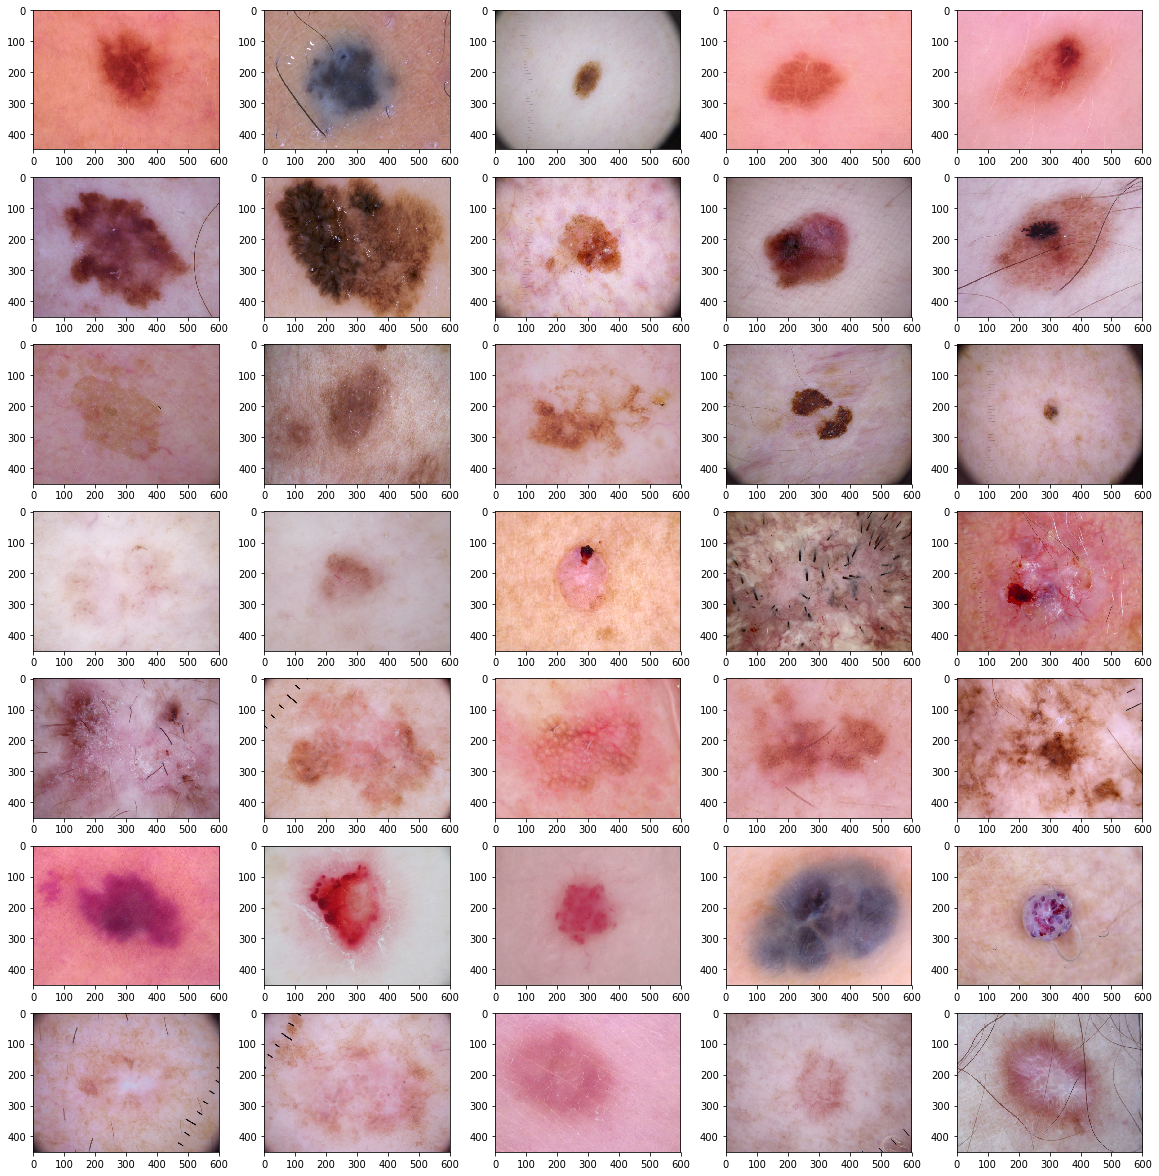

In [19]:
N_SAMPLES = 5

list_dx = df_meta['dx'].value_counts().index.tolist()
file_dx = {}

for dx in list_dx:
    file_dx[dx] = []
    image_ids = df_meta[df_meta['dx']==dx].sample(N_SAMPLES).index.tolist()
    for image_id in image_ids:
        file_dx[dx].append('./Images/{}.jpg'.format(image_id))


print('Showing images for skin cancer types {}:'.format(str(list_dx)))
        
fig, axs = plt.subplots(len(list_dx),N_SAMPLES, figsize = (4 * N_SAMPLES, 3 * len(list_dx)))
for dx in list_dx:
    for image_filename in file_dx[dx]:
        image = misc.imread(image_filename)
        axs[list_dx.index(dx)][file_dx[dx].index(image_filename)].imshow(image)

## IV. Modeling

In [103]:
def cnn(size, n_layers):
    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN

    # Define hyperparamters
    MIN_NEURONS = 64
    MAX_NEURONS = 256 # change this, make it 256, 512
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    neurons = np.arange(MIN_NEURONS, MAX_NEURONS, MIN_NEURONS/2)
    neurons = neurons.astype(np.int32)

    # Define a model
    model = Sequential()

    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(neurons[i], KERNEL, padding='same', input_shape=shape))
        else:
            model.add(Conv2D(neurons[i], KERNEL, padding='same'))
        
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
    
    # Add max pooling layer 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    # Add output layer
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [181]:
# Instantiate the model
N_LAYERS = 5
image_size = np.asarray([x_train.shape[1], x_train.shape[2], x_train.shape[3]])
model = cnn(size=image_size, n_layers=N_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 180, 135, 64)      1792      
_________________________________________________________________
activation_129 (Activation)  (None, 180, 135, 64)      0         
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 90, 67, 64)        0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 90, 67, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 90, 67, 96)        55392     
_________________________________________________________________
activation_130 (Activation)  (None, 90, 67, 96)        0         
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 45, 33, 96)        0         
__________

In [182]:
# Training hyperparamters
EPOCHS = 150
BATCH_SIZE = 256

# Add a Reduction of Learning Rate to the model in case it tapers off
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [183]:
# Train the model
model_history = model.fit(x_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[reduce_lr])

Train on 8111 samples, validate on 902 samples
Epoch 1/150
8111/8111 [==============================] - 21s 3ms/step - loss: 1.1092 - acc: 0.6549 - val_loss: 1.2938 - val_acc: 0.6918
Epoch 2/150
8111/8111 [==============================] - 16s 2ms/step - loss: 1.0142 - acc: 0.6696 - val_loss: 1.1723 - val_acc: 0.6918
Epoch 3/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.9887 - acc: 0.6696 - val_loss: 1.1001 - val_acc: 0.6918
Epoch 4/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.9778 - acc: 0.6702 - val_loss: 1.1020 - val_acc: 0.6918
Epoch 5/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.9552 - acc: 0.6711 - val_loss: 1.2483 - val_acc: 0.6973
Epoch 6/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.9256 - acc: 0.6762 - val_loss: 1.0144 - val_acc: 0.6907
Epoch 7/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.8993 - acc: 0.6730 - val_loss: 1.1271 - val_acc: 0.6851
E

Epoch 60/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.5139 - acc: 0.8048 - val_loss: 0.6378 - val_acc: 0.7572
Epoch 61/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.5074 - acc: 0.8052 - val_loss: 0.6143 - val_acc: 0.7705
Epoch 62/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.4958 - acc: 0.8078 - val_loss: 0.6300 - val_acc: 0.7550
Epoch 63/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.4880 - acc: 0.8133 - val_loss: 0.6342 - val_acc: 0.7605
Epoch 64/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.4930 - acc: 0.8131 - val_loss: 0.6267 - val_acc: 0.7616
Epoch 65/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.4987 - acc: 0.8089 - val_loss: 0.6557 - val_acc: 0.7517
Epoch 66/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.4907 - acc: 0.8117 - val_loss: 0.6206 - val_acc: 0.7627

Epoch 00066: ReduceLROnPlateau reducing 

8111/8111 [==============================] - 16s 2ms/step - loss: 0.3932 - acc: 0.8482 - val_loss: 0.6328 - val_acc: 0.7605
Epoch 116/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.3996 - acc: 0.8474 - val_loss: 0.6335 - val_acc: 0.7616
Epoch 117/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.3946 - acc: 0.8468 - val_loss: 0.6332 - val_acc: 0.7616

Epoch 00117: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 118/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.3904 - acc: 0.8529 - val_loss: 0.6334 - val_acc: 0.7627
Epoch 119/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.3924 - acc: 0.8505 - val_loss: 0.6333 - val_acc: 0.7627
Epoch 120/150
8111/8111 [==============================] - 16s 2ms/step - loss: 0.3864 - acc: 0.8492 - val_loss: 0.6342 - val_acc: 0.7639

Epoch 00120: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 121/150
8111/8111 

## V. Model Evaluation

In [184]:
# Evaluate the Model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=1, batch_size=BATCH_SIZE)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH_SIZE)

print("Train: accuracy = %f  ;  loss = %f" % (train_acc, train_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_acc, test_loss))

1002/1002 [==============================] - 1s 1ms/step
Train: accuracy = 0.877177  ;  loss = 0.356776
Test: accuracy = 0.750499  ;  loss = 0.695714


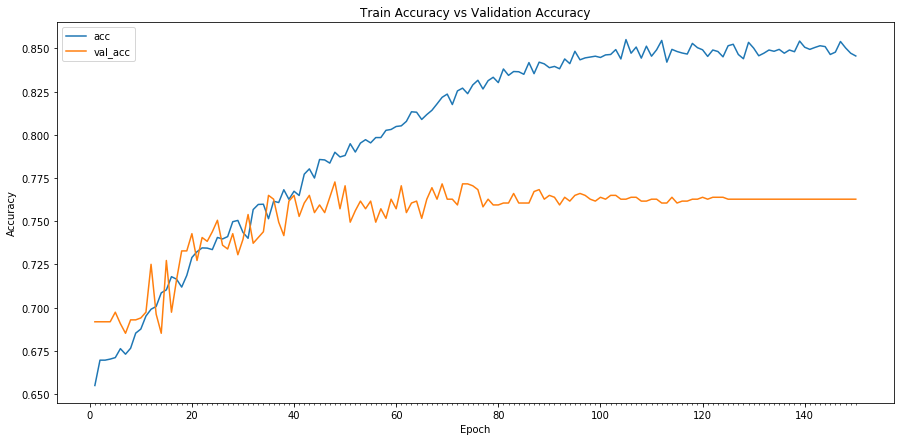

In [185]:
fig, axs = plt.subplots(1,1,figsize=(15,7))

# Plot History for Accuracy (Train vs Validation)
axs.plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
axs.plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
axs.set_title('Train Accuracy vs Validation Accuracy')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Epoch')
axs.set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
axs.legend(['acc', 'val_acc'], loc='best')

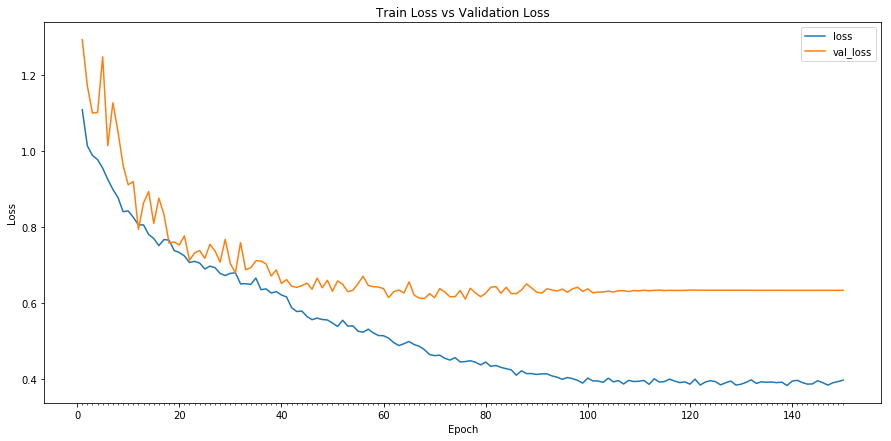

In [186]:
fig, axs = plt.subplots(1,1,figsize=(15,7))

# Plot History for Loss (Train vs Validation)
axs.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
axs.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
axs.set_title('Train Loss vs Validation Loss')
axs.set_ylabel('Loss')
axs.set_xlabel('Epoch')
axs.set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
axs.legend(['loss', 'val_loss'], loc='best')

In [187]:
# Make a prediction on the test set
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

In [188]:
# Compare the Confusion Matrix with the value counts of the test data
confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

array([[ 28,   5,   2,   0,   0,   6,   0],
       [ 21,  15,   4,   0,   0,   6,   1],
       [ 34,   5,  39,   0,   5,  42,   0],
       [  7,   1,   0,   2,   0,   5,   0],
       [ 32,   1,   7,   0,  23,  47,   0],
       [ 34,   3,   4,   1,   8, 599,   0],
       [  2,   0,   0,   0,   0,   1,  12]])

In [189]:
y_test.sum(axis=0)

dx_akiec     41
dx_bcc       47
dx_bkl      125
dx_df        15
dx_mel      110
dx_nv       649
dx_vasc      15
dtype: int64

In [190]:
# Check the Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.17      0.26        41
           1       0.50      0.32      0.39        47
           2       0.70      0.31      0.43       125
           3       0.67      0.13      0.22        15
           4       0.64      0.21      0.32       110
           5       0.85      0.92      0.88       649
           6       0.92      0.80      0.86        15

   micro avg       0.81      0.70      0.75      1002
   macro avg       0.69      0.41      0.48      1002
weighted avg       0.78      0.70      0.71      1002
 samples avg       0.70      0.70      0.70      1002



## VI. Summary
- There is a huge data imbalance which some of the data to be misclassified as nv
- Classes with the exception of 'nv' and 'vasc' have low recall but slightly acceptable precision, will require another model to run these classes by itself for better identification or more sample images can be included either by oversampling manually or manually adding new images
- Overall, the model can identify images but there is still room for improvement

In [90]:
# Save the Model
model.save('model-final-rev1.h5')